In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')

## Load dataset

In [5]:
def build_dataset(data_dict):
    time = []
    data = []
    I_p = []
    for index, contents in data_dict.items():
        time.append(contents['time'])
        data.append(contents['data'])
        I_p.append(contents['I_p'])
    
    data = np.array(data)
    x_data = data[:-1,:]
    y_data = data[1:,:]
    dt_data = (time[1] - time[0]) * np.ones((data.shape[0] -1 , 1))
    I_p = np.reshape(np.array(I_p)[:-1], (-1,1))
    u_data = np.concatenate((dt_data, I_p), axis = 1)
    return x_data, y_data, u_data

In [6]:
import numpy as np
import os

x_dataset = []
y_dataset = []
u_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u_data = build_dataset(data_dict)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        u_dataset.append(u_data)
    else:
        print(f"File not found: {data_file_path}")


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [13]:
x_data = np.concatenate(x_dataset, axis = 0)
y_data = np.concatenate(y_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)
dt = u_data[:,0:1]
Ip = u_data[:,1:2]
x_data.shape

(7221, 6957)

In [17]:
x_data_dt = x_data * dt
Ip_dt = Ip * dt
X = np.hstack([x_data_dt, Ip_dt])
K_B, _, _, _ = np.linalg.lstsq(X, y_data - x_data, rcond=None)
num_features_x = x_data.shape[1]
K = K_B[:num_features_x, :]
B = K_B[num_features_x:, :]

In [18]:
B.shape

(1, 6957)

In [50]:
def dmd_predictor(initial_data, u_data, steps, S, U, VT, B):
    data_traj = []
    
    initial_data = initial_data.reshape((1, -1))
    
    x = initial_data
    
    data_traj.append(x)
    
    I = np.eye(x.shape[1])
    
    for step in range(steps):
        u = u_data[step,:]
        x = x + x @ (I + u[0] * U @ S @ VT) + u[0] * u[1] * B
        data_traj.append(x)
    return data_traj


In [51]:
U, S, VT = np.linalg.svd(K)

KeyboardInterrupt: 

In [52]:
S[:10]

array([7.86040617e+11, 2.85307036e+11, 6.08082476e+10, 2.61795482e+10,
       2.55157044e+10, 2.25330377e+10, 1.29792595e+10, 1.00999143e+10,
       9.37822399e+09, 5.91347703e+09])

In [53]:
S_reduce = [S[i] for i in range(len(S)) if S[i] > 1e7]
U_reduce = U[:, :len(S_reduce)]
VT_reduce = VT[:len(S_reduce),:]
len(S_reduce)

50

In [56]:
S_reduce_matrix = S_reduce * np.eye(len(S_reduce))

In [57]:
import numpy as np
import torch
steps = 50
i = 0

pred_data_traj = []
for x, u in zip(x_dataset, u_dataset):
    print(i)
    i = i+1
    x_pred_traj = dmd_predictor(x[0, :], u, steps, S_reduce_matrix, U_reduce, VT_reduce, B)    
    pred_data_traj.append(x_pred_traj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [58]:
errors = [pred_data_traj[i] - x_dataset[i][:51, :] for i in range(len(pred_data_traj))]

# Calculate the norm of the error for each element
error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

# Calculate the norm of the original data for each element
data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]


# Calculate the ratio of the error norm to the data norm for each element
relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))]

# Calculate the mean and standard deviation of the relative errors for each element
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)

/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [62]:
errors

[array([[[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
           0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
         [ 5.79387813e-002,  6.07176755e-003, -1.13106544e-003, ...,
           3.68249214e-003,  3.59915196e-003, -2.56003798e-002],
         [ 1.04757597e-001,  1.09780606e-002, -2.04450748e-003, ...,
           6.03230947e-003,  5.94167779e-003, -4.32632224e-002],
         ...,
         [-3.55667193e-002, -3.72615302e-003,  6.90527296e-004, ...,
           3.58428727e-003,  3.11872354e-003, -1.39901829e-002],
         [-4.79645294e-003, -5.01546315e-004,  8.97921836e-005, ...,
           4.58800846e-003,  4.16068383e-003, -2.32210454e-002],
         [ 3.70074627e-002,  3.87927316e-003, -7.26100926e-004, ...,
           6.26938918e-003,  5.86102001e-003, -3.66774361e-002]],
 
        [[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
           0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
         [ 5.79387813e-002,  6.07176755e-003,

ValueError: too many values to unpack (expected 1)

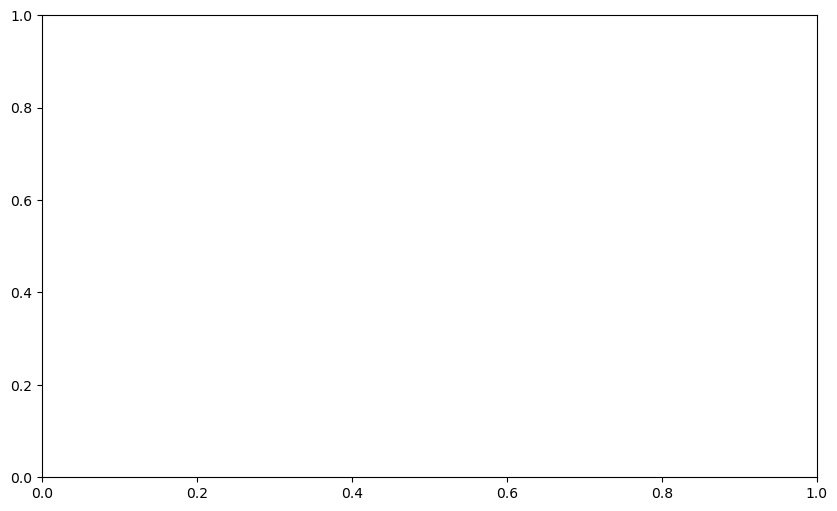

In [61]:
# Plot the relative error with error bars
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(range(51), mean_relative_errors, yerr=std_relative_errors, fmt='o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [60]:
np.mean(domain_relative_error)

NameError: name 'domain_relative_error' is not defined

In [ ]:
np.std(domain_relative_error)